In [21]:
import pandas as pd
import string
import nltk
import re
import matplotlib.pyplot as plt

# EDA for Yelp Dataset

In [22]:
reviews = pd.read_json('data/reviews_1500k.json', lines=True)

In [23]:
reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [24]:
reviews['clean_text'] = reviews['text']

### Removing unnecessary characters

In [25]:
# Remove unnecessary characters here
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [x.replace("*", "").\
                                                   replace("#", "").\
                                                   replace("-", "")][0])

### Remove punctuation

In [26]:
# Remove all punctuation
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: x.translate(str.maketrans("", "", string.punctuation)))

### Lemmatization and stemming

In [27]:
# Lemmatization and stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [ps.stem(x)][0])

### Fix contractions - DON'T RUN YET

In [28]:
from contractions import contractions_dict
nltk.download('punkt')
# Code retrieved from this page: https://medium.com/@pemagrg/pre-processing-text-in-python-ad13ea544dae
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction
    
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
    
reviews['clean_text'] = reviews['clean_text'].\
                                        apply(lambda x: [expand_contractions(x,contractions_dict)][0])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Removing stop words

In [8]:
# Download set of stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Fernando\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
reviews['clean_text'] = reviews['clean_text'].str.lower().str.split()

In [10]:
# Removing stop words
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [item for item in x if item not in stop_words_set])

### Fix Mispellings - DON'T RUN YET

In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled_wordcount = 0

def fix_misspellings(review):
    global misspelled_wordcount
    global spell
    
    misspelled = spell.unknown(review)
    
    for i in range(len(review)):
        if review[i] in misspelled:
            review[i] = spell.correction(review[i])
    
    misspelled_wordcount += len(misspelled)
    return review

reviews['clean_text'] = reviews['clean_text'].apply(lambda x: fix_misspellings(x))

### Tokenizing

In [11]:
# Convert back to string, takes a while to run
reviews['clean_text'] = reviews['clean_text'].apply(lambda x: [' '.join(x)][0])

In [12]:
from nltk.tokenize import word_tokenize
reviews['tokenized_text'] = reviews['clean_text'].apply(lambda x: word_tokenize(x))

## EDA

In [15]:
from collections import Counter
word_frequency = Counter(" ".join(reviews["clean_text"]).split())

#### Most Common Words

In [20]:
word_frequency.most_common(15)

[('food', 754326),
 ('good', 727025),
 ('place', 708822),
 ('great', 645837),
 ('like', 524044),
 ('service', 522889),
 ('time', 503528),
 ('get', 499790),
 ('one', 483259),
 ('would', 456286),
 ('back', 450526),
 ('go', 396169),
 ('really', 378180),
 ('also', 323961),
 ('us', 308031)]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

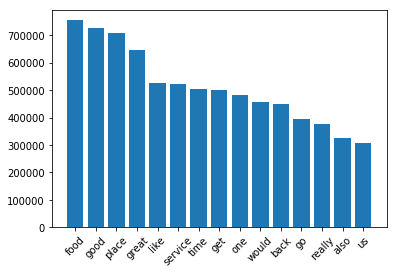

In [34]:
most_common = word_frequency.most_common(15)
plt.bar([i[0] for i in most_common], [i[1] for i in most_common])
plt.xticks(rotation=45)

#### Statistics on Review Length (after removing stop-words)

In [17]:
reviews['text_length'] = reviews['tokenized_text'].apply(lambda x: len(x))

In [19]:
reviews['text_length'].describe()

count    1.500000e+06
mean     5.708840e+01
std      5.271232e+01
min      0.000000e+00
25%      2.300000e+01
50%      4.100000e+01
75%      7.200000e+01
max      8.880000e+02
Name: text_length, dtype: float64